# core

> The core package contains all functions, variables, and classes needed to train a deep neural network model and inspect its activations.

In [ ]:
#| default_exp core

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
import math
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
import numpy as np
import sys, gc, traceback
from collections.abc import Mapping
from operator import attrgetter
from copy import copy
from functools import partial
from typing import *

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.nn import init
from torch import optim
from torch.optim.lr_scheduler import ExponentialLR

from torcheval.metrics import BinaryAccuracy, Mean, BinaryAUROC
from torcheval.metrics.functional import binary_auroc, binary_accuracy
from torchmetrics.classification import BinaryMatthewsCorrCoef

import fastcore.all as fc
from fastprogress import progress_bar, master_bar

In [ ]:
#| hide
%matplotlib inline
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)

## Load Protein Solubility Data

The example dataset is from the [DeepSol](https://doi.org/10.1093/bioinformatics/bty166) paper by Khurana *et al.* and was obtained at [https://zenodo.org/records/1162886](https://zenodo.org/records/1162886).

In [ ]:
train_sqs = open('sol_data/train_src', 'r').read().splitlines()
train_tgs = list(map(int, open('sol_data/train_tgt', 'r').read().splitlines()))
train_sqs[:2], train_tgs[:2]

(['GMILKTNLFGHTYQFKSITDVLAKANEEKSGDRLAGVAAESAEERVAAKVVLSKMTLGDLRNNPVVPYETDEVTRIIQDQVNDRIHDSIKNWTVEELREWILDHKTTDADIKRVARGLTSEIIAAVTKLMSNLDLIYGAKKIRVIAHANTTIGLPGTFSARLQPNHPTDDPDGILASLMEGLTYGIGDAVIGLNPVDDSTDSVVRLLNKFEEFRSKWDVPTQTCVLAHVKTQMEAMRRGAPTGLVFQSIAGSEKGNTAFGFDGATIEEARQLALQSGAATGPNVMYFETGQGSELSSDAHFGVDQVTMEARCYGFAKKFDPFLVNTVVGFIGPEYLYDSKQVIRAGLEDHFMGKLTGISMGCDVCYTNHMKADQNDVENLSVLLTAAGCNFIMGIPHGDDVMLNYQTTGYHETATLRELFGLKPIKEFDQWMEKMGFSENGKLTSRAGDASIFLK',
  'MAHHHHHHMSFFRMKRRLNFVVKRGIEELWENSFLDNNVDMKKIEYSKTGDAWPCVLLRKKSFEDLHKLYYICLKEKNKLLGEQYFHLQNSTKMLQHGRLKKVKLTMKRILTVLSRRAIHDQCLRAKDMLKKQEEREFYEIQKFKLNEQLLCLKHKMNILKKYNSFSLEQISLTFSIKKIENKIQQIDIILNPLRKETMYLLIPHFKYQRKYSDLPGFISWKKQNIIALRNNMSKLHRLY'],
 [1, 0])

In [ ]:
valid_sqs = open('sol_data/val_src', 'r').read().splitlines()
valid_tgs = list(map(int, open('sol_data/val_tgt', 'r').read().splitlines()))
valid_sqs[:2], valid_tgs[:2]

(['SRLYRHNLMEDVFNMENESFMQETRLMENEYSVNLPTRFYYKKRWNNGFVNIVNIFRACMVIGTPGSGKSYAIVNSYIRQLIAKGFAIYIYDYKFDDLSTIAYNSLLKNMDKYEVKPRFYVINFDDPRRSHRCNPINPEFMTDISDAYEASYTIMLNLNRTWIEKQGDFFVESPIILLAAIIWYLKIYKNGIYCTFPHAVELLNKPYSDLFTILTSYPELENYLSPFMDAWKGNAQDQLQGQIASAKIPLTRMISPQLYWVMTGNDFSLDINNPKEPKLLCVGNNPDRQNIYSAALGLYNSRIVKLINKKKQLKCAVIIDELPTIYFRGLDNLIATARSNKVGVLLGFQDFSQLTRDYGEKESKVIQNTVGNIFSGQVVGETAKTLSERFGKVLQQRQSVSINRQDVSTSINTQLDSLIPASKIANLSQGTFVGAVADNFDERIEQKIFHAEIVVDHTKISAEEKAYQKIPVINDFKDRNGNDIMMQQIQRNYDQIKADAQAIINEEMRRIKNDPELRKRLGLEDEKGKDPDKS',
  'ATTYNAVVSKSSSDGKTFKTIADAIASAPAGSTPFVILIKNGVYNERLTITRNNLHLKGESRNGAVIAAATAAGTLKSDGSKWGTAGSSTITISAKDFSAQSLTIRNDFDFPANQAKSDSDSSKIKDTQAVALYVTKSGDRAYFKDVSLVGYQATLYVSGGRSFFSDCRISGTVDFIFGDGTALFNNCDLVSRYRADVKSGNVSGYLTAPSTNINQKYGLVITNSRVIRESDSVPAKSYGLGRPWHPTTTFSDGRYADPNAIGQTVFLNTSMDNHIYGWDKMSGKDKNGNTIWFNPEDSRFFEYKSYGAGATVSKDRRQLTDAQAAEYTQSKVLGDWTPTLP'],
 [0, 1])

In [ ]:
test_sqs = open('sol_data/test_src', 'r').read().splitlines()
test_tgs = list(map(int, open('sol_data/test_tgt', 'r').read().splitlines()))
test_sqs[:2], test_tgs[:2]

(['MLSVRIAAAVARALPRRAGLVSKNALGSSFVGTRNLHASNTRLQKTGTAEMSSILEERILGADTSVDLEETGRVLSIGDGIARVHGLRNVQAEEMVEFSSGLKGMSLNLEPDNVGVVVFGNDKLIKEGDIVKRTGAIVDVPVGDELLGRVVDALGNAIDGKGPVGSKIRRRVGLKAPGIIPRISVREPMQTGIKAVDSLVPIGRGQRELIIGDRQTGKTSIAIDTIINQKRFNDGTDEKKKLYCIYVAIGQKRSTVAQLVKRLTDADAMKYTIVVSATASDAAPLQYLAPYSGCSMGEYFRDNGKHALIIYDDLSKQAVAYRQMSLLLRRPPGREAYPGDVFYLHSRLLERAAKMNDSFGGGSLTALPVIETQAGDVSAYIPTNVISITDGQIFLETELFYKGIRPAINVGLSVSRVGSAAQTRAMKQVAGTMKLELAQYREVAAFAQFGSDLDAATQQLLSRGVRLTELLKQGQYSPMAIEEQVAVIYAGVRGYLDKLEPSKITKFESAFLSHVVSQHQSLLGNIRSDGKISEQSDAKLKEIVTNFLAGFEP',
  'MDHMISENGETSAEGSICGYDSLHQLLSANLKPELYQEVNRLLLGRNCGRSLEQIVLPESAKALSSKHDFDLQAASFSADKEQMRNPRVVRVGLIQNSIALPTTAPFSDQTRGIFDKLKPIIDAAGVAGVNILCLQEAWTMPFAFCTRERRWCEFAEPVDGESTKFLQELAKKYNMVIVSPILERDIDHGEVLWNTAVIIGNNGNIIGKHRKNHIPRVGDFNESTYYMEGDTGHPVFETVFGKIAVNICYGRHHPLNWLAFGLNGAEIVFNPSATVGELSEPMWPIEARNAAIANSYFVGSINRVGTEVFPNPFTSGDGKPQHNDFGHFYGSSHFSAPDASCTPSLSRYKDGLLISDMDLNLCRQYKDKWGFRMTARYEVYADLLAKYIKPDFKPQVVSDPLLHKNST'],
 [1, 1])

In [ ]:
len(train_sqs), len(train_tgs), len(valid_sqs), len(valid_tgs), len(test_sqs), len(test_tgs)

(62478, 62478, 6942, 6942, 1999, 1999)

Create a sorted list of amino acid sequences `aas` including an empty string for padding and determine the size of the vocabulary.

In [ ]:
aas = sorted(list(set("".join(train_sqs))) + [""])
vocab_size = len(aas)
aas, vocab_size

(['',
  'A',
  'C',
  'D',
  'E',
  'F',
  'G',
  'H',
  'I',
  'K',
  'L',
  'M',
  'N',
  'P',
  'Q',
  'R',
  'S',
  'T',
  'V',
  'W',
  'Y'],
 21)

Create dictionaries that translate between string and integer representations of amino acids and define the corresponding `encode` and `decode` functions.

In [ ]:
str2int = {aa:i for i, aa in enumerate(aas)}
int2str = {i:aa for i, aa in enumerate(aas)}
encode = lambda s: [str2int[aa] for aa in s]
decode = lambda l: ''.join([int2str[i] for i in l])

print(encode("AYWCCCGGGHH"))
print(decode(encode("AYWCCCGGGHH")))

[1, 20, 19, 2, 2, 2, 6, 6, 6, 7, 7]
AYWCCCGGGHH


Figure out what the lengths of amino acid sequences in the dataset are and inspect the longest sequence.

In [ ]:
train_lens = list(map(len, train_sqs))
max(train_lens)

1691

In [ ]:
longest = train_sqs[np.argmax(train_lens)]
longest

'MSGEVRLRQLEQFILDGPAQTNGQCFSVETLLDILICLYDECNNSPLRREKNILEYLEWAKPFTSKVKQMRLHREDFEILKVIGRGAFGEVAVVKLKNADKVFAMKILNKWEMLKRAETACFREERDVLVNGDNKWITTLHYAFQDDNNLYLVMDYYVGGDLLTLLSKFEDRLPEDMARFYLAEMVIAIDSVHQLHYVHRDIKPDNILMDMNGHIRLADFGSCLKLMEDGTVQSSVAVGTPDYISPEILQAMEDGKGRYGPECDWWSLGVCMYEMLYGETPFYAESLVETYGKIMNHKERFQFPAQVTDVSENAKDLIRRLICSREHRLGQNGIEDFKKHPFFSGIDWDNIRNCEAPYIPEVSSPTDTSNFDVDDDCLKNSETMPPPTHTAFSGHHLPFVGFTYTSSCVLSDRSCLRVTAGPTSLDLDVNVQRTLDNNLATEAYERRIKRLEQEKLELSRKLQESTQTVQALQYSTVDGPLTASKDLEIKNLKEEIEKLRKQVTESSHLEQQLEEANAVRQELDDAFRQIKAYEKQIKTLQQEREDLNKELVQASERLKNQSKELKDAHCQRKLAMQEFMEINERLTELHTQKQKLARHVRDKEEEVDLVMQKVESLRQELRRTERAKKELEVHTEALAAEASKDRKLREQSEHYSKQLENELEGLKQKQISYSPGVCSIEHQQEITKLKTDLEKKSIFYEEELSKREGIHANEIKNLKKELHDSEGQQLALNKEIMILKDKLEKTRRESQSEREEFESEFKQQYEREKVLLTEENKKLTSELDKLTTLYENLSIHNQQLEEEVKDLADKKESVAHWEAQITEIIQWVSDEKDARGYLQALASKMTEELEALRNSSLGTRATDMPWKMRRFAKLDMSARLELQSALDAEIRAKQAIQEELNKVKASNIITECKLKDSEKKNLELLSEIEQLIKDTEELRSEKGIEHQDSQHSFLAFLNTPTDALDQFERKTHQFFVKSFTTPTKCHQCTSLMVGLIRQG

Check how many sequences in the training set are longer than 1200 amino acids.

In [ ]:
long_sqs = []
for sq in train_sqs:
    if len(sq) > 1200:
        long_sqs.append(sq)
len(long_sqs)

132

Create a function that drops all sequences above a chosen threshold and also returns a list of indices of the sequences that meet the threshold that can be used to obtain the correct labels.

In [ ]:
def drop_long_sqs(sqs, threshold=1200):
    new_sqs = []
    idx = []
    for i, sq in enumerate(sqs):
        if len(sq) <= threshold:
            new_sqs.append(sq)
            idx.append(i)
    return new_sqs, idx

Drop all sequences above your threshold.

In [ ]:
trnsqs, trnidx = drop_long_sqs(train_sqs, threshold=200)
vldsqs, vldidx = drop_long_sqs(valid_sqs, threshold=200)
tstsqs, tstidx = drop_long_sqs(test_sqs, threshold=200)

In [ ]:
len(trnidx), len(vldidx), len(tstidx)

(18066, 1971, 699)

Make sure that it worked.

In [ ]:
trnls = map(len, trnsqs)
vldls = map(len, vldsqs)
tstls = map(len, tstsqs)
max(trnls), max(vldls), max(tstls)

(200, 200, 200)

Create a function for zero padding all sequences.

In [ ]:
def zero_pad(sq, length=1200):
    new_sq = sq.copy()
    if len(new_sq) < length:
        new_sq.extend([0] * (length-len(new_sq)))
    return new_sq

Now encode and zero pad all sequences and make sure that it worked out correctly.

In [ ]:
trn = list(map(encode, trnsqs))
vld = list(map(encode, vldsqs))
tst = list(map(encode, tstsqs))
print(f"Length of the first two sequences before zero padding: {len(trn[0])}, {len(trn[1])}")
trn = list(map(partial(zero_pad, length=200), trn))
vld = list(map(partial(zero_pad, length=200), vld))
tst = list(map(partial(zero_pad, length=200), tst))
print(f"Length of the first two sequences after zero padding:  {len(trn[0])}, {len(trn[1])}");

Length of the first two sequences before zero padding: 116, 135
Length of the first two sequences after zero padding:  200, 200


Convert the data to `torch.tensor`s unsing `dtype=torch.int64` and check for correctness.

In [ ]:
trntns = torch.tensor(trn, dtype=torch.int64)
vldtns = torch.tensor(vld, dtype=torch.int64)
tsttns = torch.tensor(tst, dtype=torch.int64)
trntns.shape, trntns[0]

(torch.Size([18066, 200]),
 tensor([11,  9,  1, 10,  2, 10, 10, 10, 10, 13, 18, 10,  6, 10, 10, 18, 16, 16,  9, 17, 10,  2, 16, 11,  4,  4,  1,  8, 12,  4, 15,  8, 14,
          4, 18,  1,  6, 16, 10,  8,  5, 15,  1,  8, 16, 16,  8,  6, 10,  4,  2, 14, 16, 18, 17, 16, 15,  6,  3, 10,  1, 17,  2, 13, 15,  6,
          5,  1, 18, 17,  6,  2, 17,  2,  6, 16,  1,  2,  6, 16, 19,  3, 18, 15,  1,  4, 17, 17,  2,  7,  2, 14,  2,  1,  6, 11,  3, 19, 17,
          6,  1, 15,  2,  2, 15, 18, 14, 13, 10,  4,  7,  7,  7,  7,  7,  7,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0]))

In [ ]:
trntns.shape, vldtns.shape, tsttns.shape

(torch.Size([18066, 200]), torch.Size([1971, 200]), torch.Size([699, 200]))

Obtain the correct labels using the lists of indices obtained from the `drop_long_sqs` function and convert the lists of labels to tensors in `torch.float32` format.

In [ ]:
trnlbs = torch.tensor(train_tgs, dtype=torch.float32)[trnidx]
vldlbs = torch.tensor(valid_tgs, dtype=torch.float32)[vldidx]
tstlbs = torch.tensor(test_tgs, dtype=torch.float32)[tstidx]
trnlbs.shape, vldlbs.shape, tstlbs.shape

(torch.Size([18066]), torch.Size([1971]), torch.Size([699]))

In [ ]:
trnlbs.sum().item()/trnlbs.shape[0], vldlbs.sum().item()/vldlbs.shape[0], tstlbs.sum().item()/tstlbs.shape[0]

(0.4722129967895494, 0.4657534246575342, 0.5665236051502146)

Above ratios tell us that there are slightly less than half soluble proteins in the training an validation data, and slightly more than half in the test set.

## Dataset and DataLoaders

Create a `Dataset` class and combine tokens and labels into datasets.

In [ ]:
#| export
class Dataset():
    "Combines features and lables in a dataset."
    def __init__(self, x, y): self.x, self.y = x, y
    def __len__(self): return len(self.x)
    def __getitem__(self, i): return self.x[i], self.y[i]

In [ ]:
trnds = Dataset(trntns, trnlbs)
vldds = Dataset(vldtns, vldlbs)
tstds = Dataset(tsttns, tstlbs)
trnds[0]

(tensor([11,  9,  1, 10,  2, 10, 10, 10, 10, 13, 18, 10,  6, 10, 10, 18, 16, 16,  9, 17, 10,  2, 16, 11,  4,  4,  1,  8, 12,  4, 15,  8, 14,
          4, 18,  1,  6, 16, 10,  8,  5, 15,  1,  8, 16, 16,  8,  6, 10,  4,  2, 14, 16, 18, 17, 16, 15,  6,  3, 10,  1, 17,  2, 13, 15,  6,
          5,  1, 18, 17,  6,  2, 17,  2,  6, 16,  1,  2,  6, 16, 19,  3, 18, 15,  1,  4, 17, 17,  2,  7,  2, 14,  2,  1,  6, 11,  3, 19, 17,
          6,  1, 15,  2,  2, 15, 18, 14, 13, 10,  4,  7,  7,  7,  7,  7,  7,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0]),
 tensor(0.))

Define a `DataLoaders` class and a function that creates your DataLoaders given a train dataset, a valid dataset, and a batch size. 

In [ ]:
#| export
class DataLoaders():
    "Combines training and validation data in a DataLoaders object that can be passed to a learner."
    def __init__(self, *dls): self.train, self.valid = dls[:2]

In [ ]:
#| export
from torch.utils.data import DataLoader

In [ ]:
#| export
def get_dls(train_ds, valid_ds, bs=32):
    "Turn training and validation set into a DataLoaders object."
    train_dl = DataLoader(train_ds, bs, shuffle=True)
    valid_dl = DataLoader(valid_ds, bs, shuffle=False)
    return DataLoaders(train_dl, valid_dl)

Get the DataLoaders object and test it.

In [ ]:
dls = get_dls(trnds, vldds)
next(iter(dls.train))[0][:5], next(iter(dls.train))[1][:5]

(tensor([[ 4, 16, 20,  1,  8,  5, 16, 10, 12,  1, 14,  5,  3,  1, 10, 17,  8, 12,  9,  1, 15,  9, 10, 20, 15,  6,  9, 17, 15, 10, 10, 14,  6,
          14, 15,  8,  4, 10, 16,  3, 19, 13,  4, 17, 16, 18,  4, 15, 17,  4,  5, 20, 15, 20, 10, 10, 12,  9, 12, 10,  1, 14, 11, 12,  1,  7,
          19,  1, 16, 10, 16,  5, 16,  6,  9,  1, 15, 13, 13,  9, 18,  8,  3, 14, 13, 16,  8,  4,  8, 10, 10,  1, 19, 11, 15,  4, 14, 13, 12,
          15,  8,  6, 20,  1, 13, 18,  3, 16, 10, 13, 16,  3,  1,  7, 18, 10, 20, 18, 18,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
           0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
           0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
           0,  0],
         [ 6,  8,  3, 13,  5, 17, 11, 10,  7,  8,  4,  5,  8, 17,  3, 10,  6,  1,  9, 18, 17, 18,  3, 18,  4, 16,  1,  3,  9, 10,

## Learner Framework and Callbacks

The flexible callback learner along with the useful callbacks and functions below are obtained from the [fast.ai 2022 course lesson 16](https://course.fast.ai/Lessons/lesson16.html) (see also on [GitHub](https://github.com/fastai/course22p2/blob/master/nbs/09_learner.ipynb)) and might be adapted depending on what I find most useful along the way.

Figure out which acceleration device is available and define a functin that sends objects to that device.

In [ ]:
#| export
def_device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'

def to_device(x, device=def_device):
    if isinstance(x, Mapping): return {k:v.to(device) for k, v in x.items()}
    return type(x)(o.to(device) for o in x)

Define a function that sends objects to the cpu.

In [ ]:
#| export
def to_cpu(x):
    if isinstance(x, Mapping): return {k:to_cpu(v) for k,v in x.items()}
    if isinstance(x, list): return [to_cpu(o) for o in x]
    if isinstance(x, tuple): return tuple(to_cpu(list(x)))
    res = x.detach().cpu()
    return res.float() if res.dtype==torch.float16 else res

Define exceptions that end the learning process.

In [ ]:
#| export
class CancelFitException(Exception): pass
class CancelBatchException(Exception): pass
class CancelEpochException(Exception): pass

Define a callback class that assigns an order to each callback.

In [ ]:
#| export
class Callback(): order = 0

Define a class to be used in the Learner as a context manager to handle callbacks.

In [ ]:
#| export
class with_cbs:
    def __init__(self, nm): self.nm = nm
    def __call__(self, f):
        def _f(o, *args, **kwargs):
            try:
                o.callback(f'before_{self.nm}')
                f(o, *args, **kwargs)
                o.callback(f'after_{self.nm}')
            except globals()[f'Cancel{self.nm.title()}Exception']: pass
            finally: o.callback(f'cleanup_{self.nm}')
        return _f

Define a function that runs callbacks in a list of callbacks.

In [ ]:
#| export
def run_cbs(cbs, method_nm, learn=None):
    for cb in sorted(cbs, key=attrgetter('order')):
        method = getattr(cb, method_nm, None)
        if method is not None: method(learn)

Define the learner class.

In [ ]:
#| export
class Learner():
    def __init__(self, model, dls=(0,), loss_func=F.mse_loss, lr=0.1, cbs=None, opt_func=optim.SGD):
        cbs = fc.L(cbs)
        fc.store_attr()

    @with_cbs('batch')
    def _one_batch(self):
        self.predict()
        self.callback('after_predict')
        self.get_loss()
        self.callback('after_loss')
        if self.training:
            self.backward()
            self.callback('after_backward')
            self.step()
            self.callback('after_step')
            self.zero_grad()

    @with_cbs('epoch')
    def _one_epoch(self):
        for self.iter,self.batch in enumerate(self.dl): self._one_batch()

    def one_epoch(self, training):
        self.model.train(training)
        self.dl = self.dls.train if training else self.dls.valid
        self._one_epoch()

    @with_cbs('fit')
    def _fit(self, train, valid):
        for self.epoch in self.epochs:
            if train: self.one_epoch(True)
            if valid: torch.no_grad()(self.one_epoch)(False)

    def fit(self, n_epochs=1, train=True, valid=True, cbs=None, lr=None):
        cbs = fc.L(cbs)
        # `add_cb` and `rm_cb` were added in lesson 18
        for cb in cbs: self.cbs.append(cb)
        try:
            self.n_epochs = n_epochs
            self.epochs = range(n_epochs)
            if lr is None: lr = self.lr
            if self.opt_func: self.opt = self.opt_func(self.model.parameters(), lr)
            self._fit(train, valid)
        finally:
            for cb in cbs: self.cbs.remove(cb)

    def __getattr__(self, name):
        if name in ('predict','get_loss','backward','step','zero_grad'): return partial(self.callback, name)
        raise AttributeError(name)

    def callback(self, method_nm): run_cbs(self.cbs, method_nm, self)
    
    @property
    def training(self): return self.model.training

Define a class that inherits from learner that has all the functions needed for training without requiring a train callback.

In [ ]:
#| export
class TrainLearner(Learner):
    def predict(self): self.preds = self.model(self.batch[0])
    def get_loss(self): self.loss = self.loss_func(self.preds, self.batch[1])
    def backward(self): self.loss.backward()
    def step(self): self.opt.step()
    def zero_grad(self): self.opt.zero_grad()

Create a callback that assigns model and batches to the available acceleration device.

In [ ]:
#| export
class DeviceCB(Callback):
    def __init__(self, device=def_device): fc.store_attr()
    def before_fit(self, learn): learn.model.to(self.device)
    def before_batch(self, learn): learn.batch = to_device(learn.batch, device=self.device)

Define a callback that runs for a single batch for testing purposes.

In [ ]:
#| export
class SingleBatchCB(Callback):
    order = 1
    def after_batch(self, learn): raise CancelFitException()

Create a training callback that provides the learner with all functions necessary for training.

In [ ]:
#| export
class TrainCB(Callback):
    def __init__(self, n_inp=1): self.n_inp = n_inp
    def predict(self, learn): learn.preds = learn.model(*learn.batch[:self.n_inp])
    def get_loss(self, learn): learn.loss = learn.loss_func(learn.preds, *learn.batch[self.n_inp:])
    def backward(self, learn): learn.loss.backward()
    def step(self, learn): learn.opt.step()
    def zero_grad(self, learn): learn.opt.zero_grad()

Define scheduler callbacks that adjust the learning rate according to a schedule along with a callback that tracks the learining rate applied on every step.

In [ ]:
#| export
class BaseSchedCB(Callback):
    def __init__(self, sched=None):
        self.sched = sched
    def before_fit(self, learn): 
        if self.sched == None:
            self.sched = partial(torch.optim.lr_scheduler.OneCycleLR, max_lr=learn.lr, total_steps=learn.n_epochs*len(learn.dls.train))
        self.schedobj = self.sched(learn.opt)
    def step(self, learn):
        if learn.training: self.schedobj.step()

class BatchSchedCB(BaseSchedCB):
    def after_batch(self, learn): self.step(learn)
        
class EpochSchedCB(BaseSchedCB):
    def after_epoch(self, learn): self.step(learn)
        
class RecorderCB(Callback):
    def __init__(self, **d): self.d = d
    def before_fit(self, learn):
        self.recs = {k:[] for k in self.d}
        self.pg = learn.opt.param_groups[0]
    def after_batch(self, learn):
        if not learn.training: return
        for k, v in self.d.items():
            self.recs[k].append(v(self))
    def plot(self):
        for k, v in self.recs.items():
            plt.figure(figsize=(5, 3))
            plt.plot(v, label=k)
            plt.legend()
            plt.show()
            
def _lr(cb): return cb.pg['lr']
def _beta1(cb): return cb.pg['betas'][0]
def _beta2(cb): return cb.pg['betas'][1]

Define a metrics callback that facilitates calculation of metrics along with a progress callback that enables the display of metrics, loss, and plots that show the training progress during training.

In [ ]:
#| export
class MetricsCB(Callback):
    def __init__(self, *ms, **metrics):
        for o in ms: metrics[type(o).__name__] = o
        self.metrics = metrics
        self.all_metrics = copy(metrics)
        self.all_metrics["loss"] = self.loss = Mean()

    def _log(self, d): print(d)
    def before_fit(self, learn): learn.metrics = self
    def before_epoch(self, learn): [o.reset() for o in self.all_metrics.values()]
    def after_epoch(self, learn): 
        log = {k:f"{v.compute():.3f}" for k, v in self.all_metrics.items()}
        log['epoch'] = learn.epoch
        log['train'] = 'train' if learn.model.training else 'eval'
        log = {k: str(v) for k, v in log.items()}
        self._log(log)
    
    def after_batch(self, learn):
        x, y = to_cpu(learn.batch)
        for m in self.metrics.values(): m.update(to_cpu(learn.preds), y)
        self.loss.update(to_cpu(learn.loss), weight=len(x))

In [ ]:
#| export
class ProgressCB(Callback):
    order = MetricsCB.order+1
    def __init__(self, plot=False): self.plot = plot
    def before_fit(self, learn):
        learn.epochs = self.mbar = master_bar(learn.epochs)
        self.first = True
        if hasattr(learn, 'metrics'): learn.metrics._log = self._log
        self.losses = []
        self.val_losses = []

    def _log(self, d):
        if self.first:
            self.mbar.write(list(d), table=True)
            self.first = False
        self.mbar.write(list(d.values()), table=True)

    def before_epoch(self, learn): learn.dl = progress_bar(learn.dl, leave=False, parent=self.mbar)
    def after_batch(self, learn):
        learn.dl.comment = f'{learn.loss:.3f}'
        if self.plot and hasattr(learn, 'metrics') and learn.training:
            self.losses.append(learn.loss.item())
            if self.val_losses: self.mbar.update_graph([[fc.L.range(self.losses), self.losses],[fc.L.range(learn.epoch).map(lambda x: (x+1)*len(learn.dls.train)), self.val_losses]])
    
    def after_epoch(self, learn): 
        if not learn.training:
            if self.plot and hasattr(learn, 'metrics'): 
                self.val_losses.append(learn.metrics.all_metrics['loss'].compute())
                self.mbar.update_graph([[fc.L.range(self.losses), self.losses],[fc.L.range(learn.epoch+1).map(lambda x: (x+1)*len(learn.dls.train)), self.val_losses]])

Finally create a learning rate finder callback and add a function to the learner that enables usage of the learning rate finder using `learn.lr_find()` syntax.

In [ ]:
#| export
class LRFinderCB(Callback):
    def __init__(self, gamma=1.3, max_mult=3, av_over=1): fc.store_attr()
    
    def before_fit(self, learn):
        self.sched = ExponentialLR(learn.opt, self.gamma)
        self.lrs, self.losses = [],[]
        self.losses_tmp = []
        self.count = 0
        self.min = math.inf

    def after_batch(self, learn):
        self.count += 1
        if not learn.training: raise CancelEpochException()
        loss = to_cpu(learn.loss)
        self.losses_tmp.append(loss)
        if loss < self.min: self.min = loss
        if math.isnan(loss) or (loss > self.min*self.max_mult):
            raise CancelFitException()
        if self.count == self.av_over:
            self.lrs.append(learn.opt.param_groups[0]['lr'])
            self.losses.append(np.mean(self.losses_tmp))
            self.losses_tmp = []
            self.count = 0
            self.sched.step()

    def cleanup_fit(self, learn):
        plt.plot(self.lrs, self.losses)
        plt.title('Learning Rate Finder')
        plt.xlabel('learning rate')
        plt.ylabel('loss')
        plt.xscale('log')

In [ ]:
#| export
@fc.patch
def lr_find(self:Learner, gamma=1.3, max_mult=3, start_lr=1e-5, max_epochs=10, av_over=1):
    self.fit(max_epochs, lr=start_lr, cbs=LRFinderCB(gamma=gamma, max_mult=max_mult, av_over=av_over))

## Functions for Convenient Plotting of Images

In [ ]:
#| export
@fc.delegates(plt.Axes.imshow)
def show_image(im, ax=None, figsize=None, title=None, noframe=True, **kwargs):
    "Show a PIL or PyTorch image on `ax`."
    if fc.hasattrs(im, ("cpu", "permute")):
        im = im.cpu()
        if len(im.shape)==3 and im.shape[0]<5: im = im.permute(1,2,0)
    elif not isinstance(im, np.ndarray): im=np.array(im)
    if im.shape[-1]==1: im = im[..., 0]
    if ax is None: _, ax = plt.subplots(figsize=figsize)
    ax.imshow(im, **kwargs)
    if title is not None: ax.set_title(title)
    ax.set_xticks([]) 
    ax.set_yticks([]) 
    if noframe: ax.axis('off')
    return ax

In [ ]:
#| export
@fc.delegates(plt.subplots, keep=True)
def subplots(
    nrows=1, # Number of rows in returned axes grid
    ncols=1, # Number of columns in retruned axes grid
    figsize=None, # Width, height in inches of the returned figure
    imsize=3, # Size (in inches) of images that will be displayed in the returned figure
    suptitle=None, # Title to be set to returned figure
    **kwargs): # fig and axs
    """A figure and set of subplots to display images of `imsize` inches."""
    if figsize is None: figsize=(ncols*imsize, nrows*imsize)
    fig, ax = plt.subplots(nrows, ncols, figsize=figsize, **kwargs)
    if suptitle is not None: fig.suptitle(suptitle)
    if nrows*ncols==1: a = array([ax])
    return fig, ax

In [ ]:
#| export
@fc.delegates(subplots)
def get_grid(
    n, # Number of axes
    nrows=None, # Number of rows, defaulting to `int(math.sqrt(n))`
    ncols=None, # Number of columns, defaulting to `ceil(n/rows)`
    title=None, # If passed, title set to the figure
    weight='bold', # Title font weight
    size=14, # Title font size
    **kwargs): # fig and axs
    """Return a grid of `n` axes, `nrows` by `ncols`."""
    if nrows: ncols = ncols or int(np.ceil(n/nrows))
    elif ncols: nrows = nrows or int(np.ceil(n/ncols))
    else:
        nrows = int(math.sqrt(n))
        ncols = int(np.ceil(n/nrows))
    fig, axs = subplots(nrows, ncols, **kwargs)
    for i in range(n, nrows*ncols): axs.flat[i].set_axis_off()
    if title is not None: fig.suptitle(title, weight=weight, size=size)
    return fig, axs

In [ ]:
#| export
@fc.delegates(subplots)
def show_images(
    ims:list, # Images to show
    nrows=1, # Number of rows in grid
    ncols=None, # Number of columns in grid (auto-calculated if None)
    titles=None, # Optional list of titles for each image
    noframe=True, # Hide axes, yes or no
    **kwargs):
    """Show all images `ims` as subplots with `nrows` using `titles`."""
    axs = get_grid(len(ims), **kwargs)[1].flat
    for im, t, ax in zip_longest(ims, titles or [], axs): show_image(im, ax=ax, title=t, noframe=noframe)

## Activation Statistics using Hooks

In [ ]:
#| export
class Hook():
    def __init__(self, m, f): self.hook = m.register_forward_hook(partial(f, self))
    def remove(self): self.hook.remove()
    def __del__(self): self.remove()

def append_stats(hook, mod, inp, outp):
    if not hasattr(hook, 'stats'): hook.stats = ([], [])
    acts = to_cpu(outp)
    hook.stats[0].append(acts.mean())
    hook.stats[1].append(acts.std())

In [ ]:
#| export
class Hooks(list):
    def __init__(self, ms, f): super().__init__([Hook(m, f) for m in ms])
    def __enter__(self, *args): return self
    def __exit__(self, *args): self.remove()
    def __del__(self): self.remove()
    def __delitem__(self, i):
        self[i].remove()
        super().__delitem__(i)
    def remove(self):
        for h in self: h.remove()

In [ ]:
#| export
class HooksCallback(Callback):
    def __init__(self, hookfunc, mod_filter=fc.noop, on_train=True, on_valid=False, mods=None):
        fc.store_attr()
        super().__init__()
    
    def before_fit(self, learn):
        if self.mods: mods=self.mods
        else: mods = fc.filter_ex(learn.model.modules(), self.mod_filter)
        self.hooks = Hooks(mods, partial(self._hookfunc, learn))

    def _hookfunc(self, learn, *args, **kwargs):
        if (self.on_train and learn.training) or (self.on_valid and not learn.training): self.hookfunc(*args, **kwargs)

    def after_fit(self, learn): self.hooks.remove()
    def __iter__(self): return iter(self.hooks)
    def __len__(self): return len(self.hooks)

In [ ]:
#| export
def append_stats(hook, mod, inp, outp):
    if not hasattr(hook, 'stats'): hook.stats = ([], [], [])
    acts = to_cpu(outp)
    hook.stats[0].append(acts.mean())
    hook.stats[1].append(acts.std())
    hook.stats[2].append(acts.abs().histc(40, 0, 10))

In [ ]:
#| export
# Thanks to @ste for the initial version of the histogram plotting code
def get_hist(h): return torch.stack(h.stats[2]).t().float().log1p()

In [ ]:
#| export
def get_min(h):
    h1 = torch.stack(h.stats[2]).t().float()
    return h1[:2].sum(0)/h1.sum(0)

In [ ]:
#| export
class ActivationStats(HooksCallback):
    def __init__(self, mod_filter=fc.noop): super().__init__(append_stats, mod_filter)

    def color_dim(self, figsize=(11, 5)):
        fig, axs = get_grid(len(self), figsize=figsize)
        for ax, h in zip(axs.flat, self):
            show_image(get_hist(h), ax, origin='lower')
    
    def dead_chart(self, figsize=(11, 5)):
        fig, axs = get_grid(len(self), figsize=figsize)
        for ax, h in zip(axs.flat, self):
            ax.plot(get_min(h))
            ax.set_ylim(0.0, 1.1)

    def plot_stats(self, figsize=(10, 4)):
        fig, axs = subplots(1, 2, figsize=figsize)
        for h in self:
            for i in 0, 1: axs[i].plot(h.stats[i])
        axs[0].set_title('Means')
        axs[1].set_title('Stdevs')
        plt.legend(fc.L.range(self))

## Functions for Convenient Memory Management

In [ ]:
#| export
def clean_ipython_hist():
    # Code in this function mainly copied from IPython source
    if not 'get_ipython' in globals(): return
    ip = get_ipython()
    user_ns = ip.user_ns
    ip.displayhook.flush()
    pc = ip.displayhook.prompt_count + 1
    for n in range(1, pc): user_ns.pop('_i'+repr(n),None)
    user_ns.update(dict(_i='',_ii='',_iii=''))
    hm = ip.history_manager
    hm.input_hist_parsed[:] = [''] * pc
    hm.input_hist_raw[:] = [''] * pc
    hm._i = hm._ii = hm._iii = hm._i00 =  ''

In [ ]:
#| export
def clean_tb():
    # h/t Piotr Czapla
    if hasattr(sys, 'last_traceback'):
        traceback.clear_frames(sys.last_traceback)
        delattr(sys, 'last_traceback')
    if hasattr(sys, 'last_type'): delattr(sys, 'last_type')
    if hasattr(sys, 'last_value'): delattr(sys, 'last_value')

In [ ]:
#| export
def clean_mem():
    clean_tb()
    clean_ipython_hist()
    gc.collect()
    torch.cuda.empty_cache()

## Weight Initialization and General Relu

In [ ]:
#| export
def init_weights(m, leaky=0.):
    if isinstance(m, (nn.Conv1d, nn.Conv2d, nn.Conv3d, nn.Linear)): init.kaiming_normal_(m.weight, a=leaky)

In [ ]:
#| export
class GeneralRelu(nn.Module):
    def __init__(self, leak=None, sub=None, maxv=None):
        super().__init__()
        self.leak, self.sub, self.maxv = leak, sub, maxv

    def forward(self, x):
        x = F.leaky_relu(x, self.leak) if self.leak is not None else F.relu(x)
        if self.sub is not None: x -= self.sub
        if self.maxv is not None: x.clamp_max_(self.maxv)
        return x

In [ ]:
act_genrelu = partial(GeneralRelu, leak=0.1, sub=0.4)

## Training a Model

Obtain a single batch from `dls` to help with model design.

In [ ]:
idx = next(iter(dls.train))[0]
idx, idx.shape

(tensor([[16, 12, 13,  ...,  0,  0,  0],
         [11,  1, 16,  ...,  0,  0,  0],
         [11,  3,  6,  ...,  0,  0,  0],
         ...,
         [16, 19, 14,  ...,  0,  0,  0],
         [ 9, 18, 10,  ...,  0,  0,  0],
         [11, 17, 20,  ...,  0,  0,  0]]),
 torch.Size([32, 200]))

### Tiny Resnet

Design a model architecture. Define functions to obtain 1D convolutional layers with an activation function and normalization and define a 1D residual block class.

In [ ]:
#| export
def conv1d(ni, nf, ks=3, stride=2, act=nn.ReLU, norm=None, bias=None):
    if bias is None: bias = not isinstance(norm, (nn.BatchNorm1d,nn.BatchNorm2d,nn.BatchNorm3d))
    layers = [nn.Conv1d(ni, nf, stride=stride, kernel_size=ks, padding=ks//2, bias=bias)]
    if norm: layers.append(norm(nf))
    if act: layers.append(act())
    return nn.Sequential(*layers)

def _conv1d_block(ni, nf, stride, act=nn.ReLU, norm=None, ks=3):
    return nn.Sequential(conv1d(ni, nf, stride=1, act=act, norm=norm, ks=ks),
                         conv1d(nf, nf, stride=stride, act=None, norm=norm, ks=ks))

class ResBlock1d(nn.Module):
    def __init__(self, ni, nf, stride=1, ks=3, act=nn.ReLU, norm=None):
        super().__init__()
        self.convs = _conv1d_block(ni, nf, stride=stride, ks=ks, act=act, norm=norm)
        self.idconv = fc.noop if ni==nf else conv1d(ni, nf, stride=1, ks=1, act=None)
        self.pool = fc.noop if stride==1 else nn.AvgPool1d(stride, ceil_mode=True)
        self.act = act()

    def forward(self, x): return self.act(self.convs(x) + self.pool(self.idconv(x)))

Define a class that switches the rank order from BLC to BCL.

In [ ]:
#| export
class Reshape(nn.Module):
    def forward(self, x): 
        B, L, C = x.shape
        return x.view(B, C, L)

Put the model together.

In [ ]:
lr = 1e-2
epochs = 10
n_embd = 16
dls = get_dls(trnds, vldds, bs=32)

model = nn.Sequential(nn.Embedding(vocab_size, n_embd, padding_idx=0), Reshape(),
                      ResBlock1d(n_embd, 2, ks=15, stride=2, norm=nn.BatchNorm1d, act=act_genrelu), nn.Dropout(0.1),
                      ResBlock1d(2, 4, ks=13, stride=2, norm=nn.BatchNorm1d, act=act_genrelu), nn.Dropout(0.1),
                      ResBlock1d(4, 4, ks=11, stride=2, norm=nn.BatchNorm1d, act=act_genrelu), nn.Dropout(0.1),
                      ResBlock1d(4, 4, ks=9, stride=2, norm=nn.BatchNorm1d, act=act_genrelu), nn.Dropout(0.1),
                      ResBlock1d(4, 8, ks=7, stride=2, norm=nn.BatchNorm1d, act=act_genrelu), nn.Dropout(0.1),
                      ResBlock1d(8, 8, ks=5, stride=2, norm=nn.BatchNorm1d, act=act_genrelu), nn.Dropout(0.1),
                      ResBlock1d(8, 16, ks=3, stride=2, norm=nn.BatchNorm1d, act=act_genrelu), nn.Dropout(0.1),
                      ResBlock1d(16, 32, ks=3, stride=2, norm=nn.BatchNorm1d, act=act_genrelu), nn.Dropout(0.1),
                      nn.Flatten(1, -1),
                      nn.Linear(32, 1),
                      nn.Flatten(0, -1),
                      nn.Sigmoid())
model(idx).shape

torch.Size([32])

In [ ]:
iw = partial(init_weights, leaky=0.1)
model = model.apply(iw)
metrics = MetricsCB(BinaryAccuracy(), BinaryMatthewsCorrCoef(), BinaryAUROC())
rec = RecorderCB(lr=_lr, beta1=_beta1, beta2=_beta2)
astats = ActivationStats(fc.risinstance(GeneralRelu))
cbs = [DeviceCB(), BatchSchedCB(), ProgressCB(plot=False), metrics, astats, rec]
# cbs = [DeviceCB(), ProgressCB(plot=False), metrics, astats, rec] # for lr_find()
learn = TrainLearner(model, dls, F.binary_cross_entropy, lr=lr, cbs=cbs, opt_func=torch.optim.AdamW)
print(f"Parameters total: {sum(p.nelement() for p in model.parameters())}")
# learn.lr_find(start_lr=1e-4, gamma=1.05, av_over=5, max_mult=5)

Parameters total: 10175


In [ ]:
learn.fit(epochs)

BinaryAccuracy,BinaryMatthewsCorrCoef,BinaryAUROC,loss,epoch,train
0.502,-0.003,0.499,0.732,0,train
0.507,-0.022,0.480,0.701,0,eval
0.513,0.003,0.503,0.698,1,train
0.501,-0.016,0.494,0.695,1,eval
0.528,0.031,0.518,0.692,2,train
0.473,-0.014,0.490,0.695,2,eval
0.540,0.058,0.529,0.689,3,train
0.530,0.026,0.511,0.689,3,eval
0.557,0.100,0.557,0.683,4,train
0.545,0.060,0.566,0.681,4,eval


Inspect the learning rate schedule applied during training.

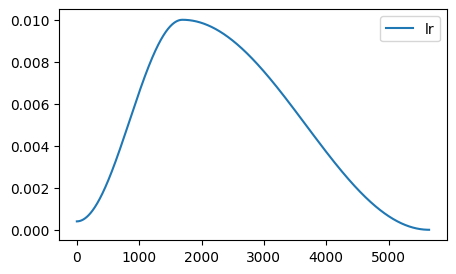

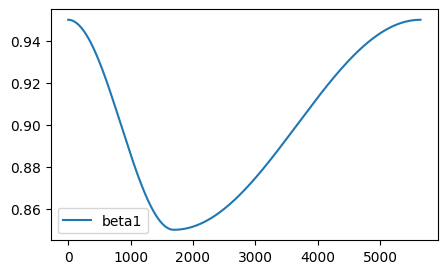

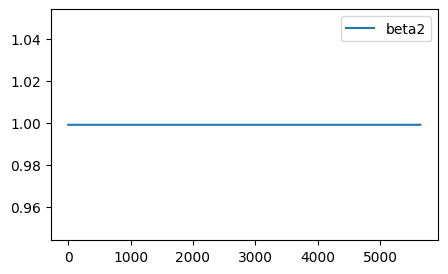

In [ ]:
rec.plot()

## Transformer Model with Skip Connections and LayerNorm

The transformer model below is adapted from the model built in Andrej Karpathy's video [Let's build GPT: from scratch, in code, spelled out](https://www.youtube.com/watch?v=kCc8FmEb1nY).

In [ ]:
#| export
class Head(nn.Module):
    """One head of self-attention."""
    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        #self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size))) # comment out if used in an encoder setting
        self.dropout = nn.Dropout(dropout) # <-- dropout added here
    def forward(self, x):
        B, T, C = x.shape
        k = self.key(x) # (B, T, head_size)
        q = self.query(x) # (B, T, head_size)
        # compute affinities
        wei = q @ k.transpose(-2, -1) * C**(-0.5) # (B, T, head_size) @ (B, head_size, T) --> (B, T, T)
        #wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # comment out if used in an encoder setting
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei) # <-- dropout added here
        v = self.value(x) # (B, T, head_size)
        out = wei @ v # (B, T, T) @ (B, head_size, T) --> (B, T, head_size)
        return out

In [ ]:
#| export
class FeedForward(nn.Module):
    """A simple linear layer followed by a non-linearity."""
    def __init__(self, n_embed):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(n_embd, 4 * n_embd), 
                                 nn.ReLU(),
                                 nn.Linear(4 * n_embd, n_embd),
                                 nn.Dropout(dropout)) # <-- dropout added here
    def forward(self, x): return self.net(x)

In [ ]:
#| export
class MultiHeadAttention(nn.Module):
    """Multiple heads of self-attention in parallel."""
    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout) # <-- dropout added here
    def forward(self, x): 
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out)) # <-- dropout added here
        return out

In [ ]:
#| export
class Block(nn.Module):
    """Transformer block: communication (attention) followed by computation."""
    def __init__(self, n_embd, n_head):
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedForward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)
    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

In [ ]:
#| export
class TransformerModel(nn.Module):
    def __init__(self, device):
        super().__init__()
        self.device = device
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd, padding_idx=0)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.lnf = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd * block_size, 1) # changed vocab_size to 1 for binary classification
        self.flat = nn.Flatten(0, -1)
    def forward(self, idx):
        B, T = idx.shape
        tok_emb = self.token_embedding_table(idx) # (B, T, C) (Batch, Time, Channel)
        pos_emb = self.position_embedding_table(torch.arange(T, device=self.device)) # (T, C)
        x = tok_emb + pos_emb # (B, T, C)
        x = self.blocks(x) # (B, T, C)
        x = self.lnf(x) # (B, T, C)
        B, T, C = x.shape
        x = x.view(B, T * C)
        logits = self.lm_head(x) # (B, 1)
        return self.flat(logits)

In [ ]:
lr = 1e-3
block_size = 200
epochs = 10
n_embd = 16
n_head = 8
n_layer = 5
dropout = 0.2

model = TransformerModel(device='cpu')
model(idx).shape

torch.Size([32])

In [ ]:
dls = get_dls(trnds, vldds, bs=32)
model = TransformerModel(device=def_device)
iw = partial(init_weights, leaky=0.1)
model = model.apply(iw)
metrics = MetricsCB(BinaryAccuracy(), BinaryMatthewsCorrCoef(), BinaryAUROC())
rec = RecorderCB(lr=_lr, beta1=_beta1, beta2=_beta2)
astats = ActivationStats(fc.risinstance(GeneralRelu))
cbs = [DeviceCB(), BatchSchedCB(), ProgressCB(plot=False), metrics, astats, rec]
learn = TrainLearner(model, dls, F.binary_cross_entropy_with_logits, lr=lr, cbs=cbs, opt_func=optim.AdamW)
print(f"Parameters total: {sum(p.nelement() for p in model.parameters())}")
#learn.lr_find(start_lr=1e-5, gamma=1.1, av_over=3, max_mult=5)

Parameters total: 22929


In [ ]:
learn.fit(epochs)

BinaryAccuracy,BinaryMatthewsCorrCoef,BinaryAUROC,loss,epoch,train
0.520,0.002,0.504,0.767,0,train
0.534,0.041,0.534,0.712,0,eval
0.535,0.051,0.537,0.713,1,train
0.539,0.222,0.626,0.692,1,eval
0.602,0.189,0.627,0.670,2,train
0.659,0.265,0.683,0.622,2,eval
0.632,0.250,0.668,0.639,3,train
0.654,0.310,0.697,0.610,3,eval
0.639,0.282,0.687,0.628,4,train
0.660,0.306,0.712,0.614,4,eval


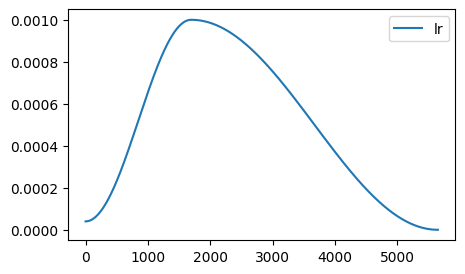

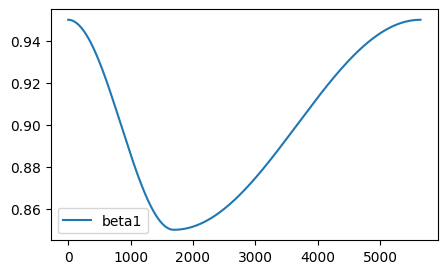

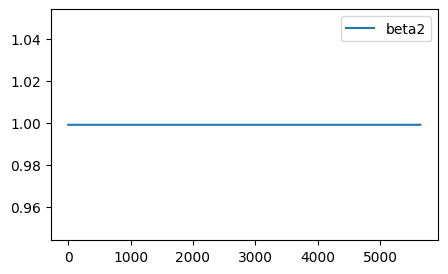

In [ ]:
rec.plot()

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()